# Brain connectome comparison using geodesic distances

Authors: S. Shailja and B.S. Manjunath

Affiliation: University of California, Santa Barbara

The goal of this notebook is to study the importance of geodesic distances on manifolds. Towards that end, we propose the following twin study. We utilize the structural connectomes of 412 human subjects in five different resolutions and two edge weights. Data consists of 206 twin pairs (133 Monozygotic (MZ) and 73 Dizygotic (DZ)).

A connectivity graph is computed from neural fiber connections between different anatomically identified Regions of Interest (ROIs) of the brain. For each subject, we have an undirected graph with 83, 129, 234, 463, and 1015 nodes and we consider the following edge weights for our study:
- number_of_fibers: the count of the fibers connecting two ROIs.
- fiber_length_mean: The mean of the fiber lengths connecting two ROIs.

We investigate the performance of geodesic distances on manifolds to assess the network similarity between pairs of twins in structural networks at different network resolutions. We compare these metrics with Euclidean distances. 


<!-- <table><tr>
<td> <img src="emg_wristband.png" style="width: 200px;"/> </td>
<td> <img src="paper_rock_scissors.png" style="width: 300px;"/> </td>
</tr></table>

Figure 1. Left: EMG device: Armband with 8 electrodes recording the electrical activity of the arm's muscle tissues. Right: Three out of the four hand gestures classes considered, here "paper", "rock", "scissors". -->

# 1. Introduction and Motivation

Diffusion Tensor Imaging (DTI) is a magnetic resonance imaging technique that discovers the connections between much larger areas of the gray matter of the human brain. In recent years, analysis of fibers in DTI has received wide interest due to its potential applications in computational pathology, surgery, and studies of diseases, such as brain tumors,  Alzheimer’s,  and schizophrenia. Among them, one way to analyze the fiber tracts is to generate a connectivity matrix that provides a compact description of pairwise connectivity of ROIs derived from anatomical or computational brain atlases. For example, the connectivity matrices can be used to compute multiple graph theory-based metrics to distinguish between the brains. However, such methods analyze the derived network parameters overlooking the actual difference between the networks.

In this research work, we assess the similarity in structural networks by comparing the connectivity matrices. We evaluate the efficacy of distance metrics in different geometrical spaces. We demonstrate the usefulness of geodesic distances that considers the complex geometric nature of the graph. Furthermore, we evaluate the performance and consistency of the results at different graph resolutions. The computed structural connectomes based on the data of the Human Connectome Project (HCP) are publicly available to download from https://braingraph.org/cms/download-pit-group-connectomes/ [[CBB2017]](#References).

## Outline

In this notebook, we will:
- Compute the Euclidean distances on adjacency matrices for each pair of twins (MZ and DZ).
- Regularize the symmetric semi-positive definite graph Laplacians to symmetric positive-definite matrices and evaluate distances on SPD manifold.
- Statistical analysis of similarity metrics with Euclidean distance as baseline using Wilcoxon rank sum non-parametric test [[CJ1985]](#References).

# 2. Analysis

We import required Python packages.

In [3]:
import numpy as np
import networkx as nx
from numpy import linalg as la
import geomstats.backend as gs
import csv
import pandas as pd
import math
import scipy.stats as stats
import geomstats.geometry.spd_matrices as spd
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

gs.random.seed(2021)

In [21]:
import sys
!{sys.executable} -m pip install seaborn
import seaborn as sns

  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c3/e2/00cacecafbab071c787019f00ad84ca3185952f6bb9bca9550ed83870d4d/pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/09/03/b7b30fa81cb687d1178e085d0f01111ceaea3bf81f9330c937fb6f6c8ca0/matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Usin

In [2]:
import sys
!{sys.executable} -m pip install networkx
import networkx as nx

    100% |████████████████████████████████| 1.6MB 312kB/s ta 0:00:011    50% |████████████████                | 808kB 13.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ed/1b/72a1821152d07cf1d8b6fce298aeb06a7eb90f4d6d41acec9861e7cc6df0/decorator-4.4.2-py2.py3-none-any.whl


In [5]:
import os
path = os.getcwd()
print(path)

/home/shailja/iclr_submission/challenge-iclr-2021/s-shailja


## 2.1. Dataset description


The connectomes generated by the PIT Bioinformatics Group can be downloaded from https://braingraph.org/cms/download-pit-group-connectomes/. 
- 86 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged (18 MB)
- 129 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged (33 MB)
- 234 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged (71 MB)
- 463 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged (138 MB)
- 1015 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged (265 MB)

The connectomes were generated from MRI scans obtained from the Human Connectome Project. To download the connectomes, you have to agree to the terms and conditions of Human Connectome Project. Please uncompress the data before running the code. A set of sample data is included in the data folder.

The metadata of each subject consists of subject id, family id, twin id and zygosity. It can be downloaded from the publicly available HCP website https://www.humanconnectome.org/study/hcp-young-adult/data-releases. We have uploaded the sample metadata as a CSV file in the data folder. Please agree to the same data use terms of the Human Connectome Project as above.

In [6]:
# save the metadata file from HCP dataset
with open(path +'/data/HCP_zygocity.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)      
    dic = {}    
    for row in reader:
        if(row['ZygosityGT'] == "MZ" or row['ZygosityGT'] == "DZ"):
            if not dic.get(row['ZygosityGT'] + "_" + row['FAMILY_ID']):
                dic[row['ZygosityGT'] + "_" + row['FAMILY_ID']] = [row['SUBJECT_ID']]
            else:
                dic[row['ZygosityGT'] + "_" + row['FAMILY_ID']].append(row['SUBJECT_ID'])              

In [7]:
print(row)
# print(dic.keys())

OrderedDict([('dbGaP_Subject_ID', '2133618'), ('FAMILY_ID', '99998_99999'), ('SUBJECT_ID', '99999'), ('Sex', '1'), ('ZygositySR', ''), ('ZygosityGT', ''), ('TWIN_ID', ''), ('Mother_ID', '0'), ('Father_ID', '0')])


We explore the dataset by showing illustrative connectivity matrices of MZ and DZ twin pairs with 83 ROIs and fiber_length_mean  as edge weight.

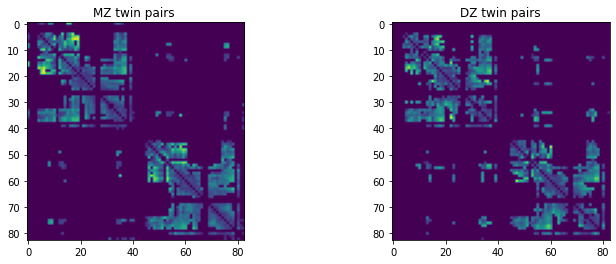

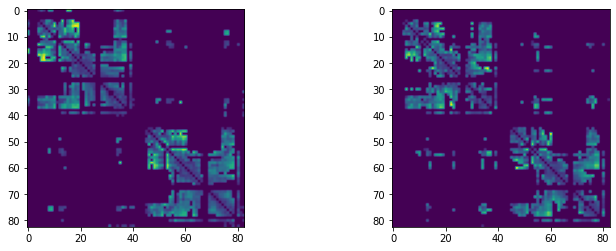

In [8]:
import matplotlib.pyplot as plt
labels_str = ['MZ twin pairs ', 'DZ twin pairs']
G1 = nx.read_graphml(path + "/data/repeated_10_scale_33/251833_repeated10_scale33.graphml")
weight = "fiber_length_mean"
A1 = nx.adjacency_matrix(G1, weight = weight).todense()
G2 = nx.read_graphml(path + "/data/repeated_10_scale_33/199655_repeated10_scale33.graphml")
weight = "fiber_length_mean"
A2 = nx.adjacency_matrix(G1, weight = weight).todense()

G1 = nx.read_graphml(path + "/data/repeated_10_scale_33/898176_repeated10_scale33.graphml")
weight = "fiber_length_mean"
A_1 = nx.adjacency_matrix(G1, weight = weight).todense()
G2 = nx.read_graphml(path + "/data/repeated_10_scale_33/109123_repeated10_scale33.graphml")
weight = "fiber_length_mean"
A_2 = nx.adjacency_matrix(G1, weight = weight).todense()

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
imgplot = ax.imshow(A1)
ax.set_title(labels_str[0])

ax = fig.add_subplot(122)
imgplot = ax.imshow(A_1)
ax.set_title(labels_str[1])
plt.show()
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
imgplot = ax.imshow(A2)


ax = fig.add_subplot(122)
imgplot = ax.imshow(A_2)
plt.show()

We can directly compare the connectivity matrices using Euclidean distance. However, the Euclidean space may not fully describe the actual geometry of the data as shown in Figure 1. So, we compute the graph Laplacian which transforms the matrices in the symmetric, semi-positive definite manifold. Finally, we regularize the graph Laplacian with a small parameter to analyze the connectivity data in the symmetric, positive-definite manifold.  

We eigen decompose raw correlation matrices and lower-bound small eigenvalues to 0.5, and re-compose them into regularized  correlation matrices to ensure that the matrices are SPD.

<table><tr>
<td> <img src="geodesic.jpeg" style="width: 200px;"/> <figcaption>Figure 1 - Euclidean distance in blue and the corresponding geodesic distance in orange along the manifold.</figcaption></td>
</tr></table>

In [9]:
def findSPD(L1):
    eigval, eigvec = np.linalg.eig(L1)
    eigval[eigval < 0.5] = 0.5
    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

Using `geomstats`, we check that these matrices belong to the space of Symmetric Positive Definite (SPD) matrices.

In [12]:
G1 = nx.read_graphml(path + "/data/repeated_10_scale_33/251833_repeated10_scale33.graphml")
weight = "fiber_length_mean"
weight = "number_of_fibers"
D1 = nx.adjacency_matrix(G1, weight = weight).todense()
L1 = nx.normalized_laplacian_matrix(G1, nodelist = G1.nodes(), weight = weight).toarray()
m = L1.shape[0]
manifold = spd.SPDMatrices(m)
print(gs.all(manifold.belongs(findSPD(L1))))

True


## 2.1. Distance functions

Euclidean Distance:
We compute the 2-norm and Frobenius norm between two connectivity matrices using `geomstats` tools. 
<!-- 


The Euclidean norm or ${\displaystyle \ell _{2}}$-norm for vectors, the induced matrix norm. -->

${\displaystyle \|A_1 - A_2\|_{2}={\sqrt {\lambda _{\max }\left((A_1 - A_2) ^{*}(A_1 - A_2)\right)}},}$

${\displaystyle \|A_1 - A_2\|_{\text{F}}={\sqrt {\sum _{i=1}^{m}\sum _{j=1}^{n}|{a_1}_{ij} - {a_2}_{ij}|^{2}}}={\sqrt {\operatorname {trace} \left((A_1 - A_2) ^{*}(A_1 - A_2)\right)}},}$
where $A_1$ and $A_2$ are adjacency matrices of a twin pair.


In [13]:
def euclidean(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    A1,A2 = [nx.adjacency_matrix(G, weight = weight).todense() for G in [G1,G2]]
    return gs.linalg.norm((A1 - A2), 2)

In [14]:
def frobenius(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    A1,A2 = [nx.adjacency_matrix(G, weight = weight).todense() for G in [G1,G2]]
    return gs.linalg.norm(A1 - A2)

We compute the  Bures-Wasserstein distance $d(A_1, A_2)$ on the manifold of n × n positive definite matrices using `geomstats` tools, where


$d(A_1, A_2)=\left[ trace\, A_1+trace\, A_2-2 \times trace(A_1^{1/2}A_2A_1^{1/2})^{1/2}\right]^{1/2}.$

In [15]:
def buresWasserstein(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    L1 = nx.normalized_laplacian_matrix(G1, nodelist = G1.nodes(), weight = weight).toarray()
    L2 = nx.normalized_laplacian_matrix(G2, nodelist = G2.nodes(), weight = weight).toarray()
    L1 = findSPD(L1)
    L2 = findSPD(L2)
    m = L2.shape[0]
    manifold2 = spd.SPDMetricBuresWasserstein(m)
    return manifold2.squared_dist(L1, L2)

## 2.2. Statistical Analysis

Euclidean distance and Bures-Wasserstein distance was computed for each pair of twins (MZ and DZ) providing group-wise statistics to investigate the impact of genetics on structural connectivity of brain networks. Our working hypotheses is that connectivity between MZ pairs would be more similar than between DZ pairs. We utilized Wilcoxon rank sum non-parametric test given the small sample size. We compare the p-values for both the metrics to highlight the sensitivity towards manifolds.

In [20]:
# For number of nodes = 234:
d_MZ_fiber_length_mean_E = []
d_DZ_fiber_length_mean_E = []

d_MZ_number_of_fibers_E = []
d_DZ_number_of_fibers_E = []

d_MZ_fiber_length_mean_B = []
d_DZ_fiber_length_mean_B = []

d_MZ_number_of_fibers_B = []
d_DZ_number_of_fibers_B = []

for key in dic.keys():
    try:
        G1 = nx.read_graphml(path + "/data/repeated_10_scale_234nodes/"+ dic[key][0] +"_repeated10_scale125.graphml")
        G2 = nx.read_graphml(path + "/data/repeated_10_scale_234nodes/" + dic[key][1] +"_repeated10_scale125.graphml")
#         G1 = nx.read_graphml("/mnt/c/Users/shail/Downloads/repeated_10_scale_234nodes/"+ dic[key][0] +"_repeated10_scale125.graphml")
#         G2 = nx.read_graphml("/mnt/c/Users/shail/Downloads/repeated_10_scale_234nodes/" + dic[key][1] +"_repeated10_scale125.graphml")
        if (key.split("_")[0] == "MZ"):
            d_m = euclidean(G1, G2, "fiber_length_mean")            
            d_MZ_fiber_length_mean_E.append(d_m)
            d_m = euclidean(G1, G2, "number_of_fibers")            
            d_MZ_number_of_fibers_E.append(d_m)

            d_m = buresWasserstein(G1, G2, "fiber_length_mean")            
            d_MZ_fiber_length_mean_B.append(d_m)
            d_m = buresWasserstein(G1, G2, "number_of_fibers")            
            d_MZ_number_of_fibers_B.append(d_m)

        elif (key.split("_")[0] == "DZ"):            
            d_d = euclidean(G1, G2, "fiber_length_mean")              
            d_DZ_fiber_length_mean_E.append(d_d)
            d_d = euclidean(G1, G2, "number_of_fibers")
            d_DZ_number_of_fibers_E.append(d_d)

            d_d = buresWasserstein(G1, G2, "fiber_length_mean")              
            d_DZ_fiber_length_mean_B.append(d_d)
            d_d = buresWasserstein(G1, G2, "number_of_fibers")
            d_DZ_number_of_fibers_B.append(d_d)

    except:
        continue

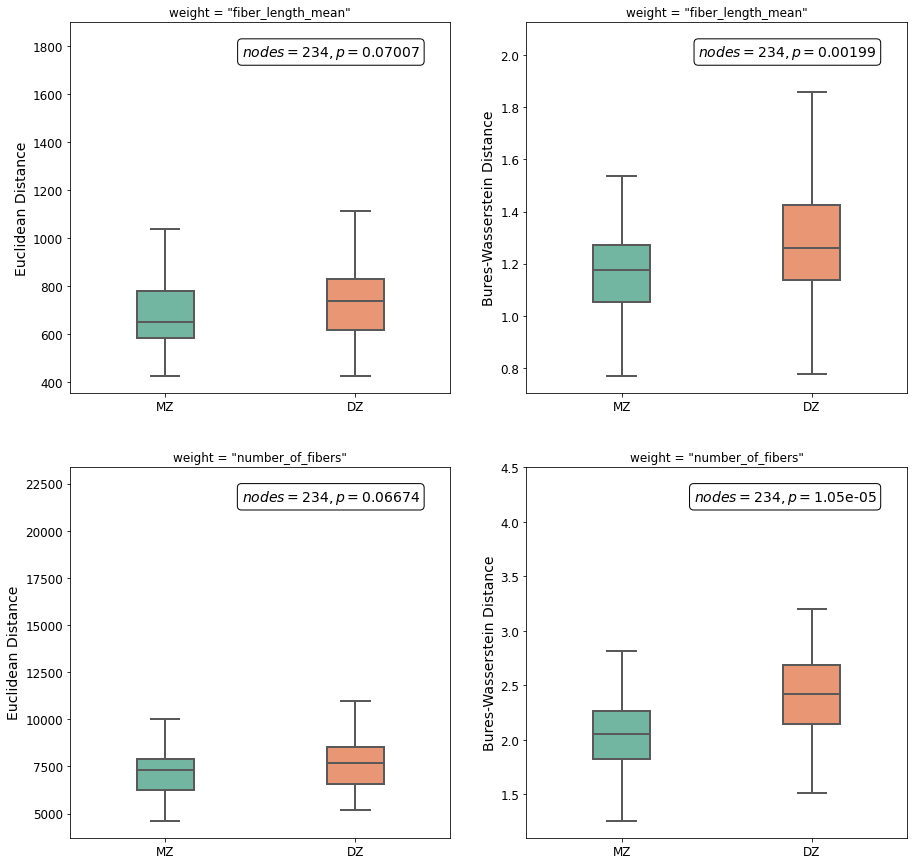

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
cmap = sns.color_palette("Set2");
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
mpl.rc('axes', labelsize=14)
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)

d = pd.DataFrame(list(zip(d_MZ_fiber_length_mean_E, d_DZ_fiber_length_mean_E)), 
               columns =['MZ', 'DZ']) 
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])
ax = sns.boxplot( data=d, fliersize = 0.01, width = 0.3, linewidth = 2,palette = cmap)
ax.annotate('$nodes = 234, p = $'+ str(round(pvalue,5)), xy=(350, 350), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
# plt.figure(figsize=(6,6))
plt.ylabel('Euclidean Distance')
plt.title('weight = "fiber_length_mean"')

plt.subplot(2, 2, 3)
d = pd.DataFrame(list(zip(d_MZ_number_of_fibers_E, d_DZ_number_of_fibers_E)), 
               columns =['MZ', 'DZ']) 
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])
ax = sns.boxplot( data=d, fliersize = 0.01, width = 0.3, linewidth = 2,palette = cmap)
ax.annotate('$nodes = 234, p = $'+ str(round(pvalue,5)), xy=(350, 350), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
plt.ylabel('Euclidean Distance')
plt.title('weight = "number_of_fibers"')

plt.subplot(2, 2, 2)

d = pd.DataFrame(list(zip(d_MZ_fiber_length_mean_B, d_DZ_fiber_length_mean_B)), 
               columns =['MZ', 'DZ']) 
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])
ax = sns.boxplot( data=d, fliersize = 0.01, width = 0.3, linewidth = 2,palette = cmap)
ax.annotate('$nodes = 234, p = $'+ str(round(pvalue,5)), xy=(350, 350), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
# plt.figure(figsize=(6,6))
plt.ylabel('Bures-Wasserstein Distance')
plt.title('weight = "fiber_length_mean"')

plt.subplot(2, 2, 4)
d = pd.DataFrame(list(zip(d_MZ_number_of_fibers_B, d_DZ_number_of_fibers_B)), 
               columns =['MZ', 'DZ']) 
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])
ax = sns.boxplot( data=d, fliersize = 0.01, width = 0.3, linewidth = 2,palette = cmap)
ax.annotate('$nodes = 234, p = $'+ str(round(pvalue,7)), xy=(350, 350), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
plt.ylabel('Bures-Wasserstein Distance')
plt.title('weight = "number_of_fibers"')

plt.show()




We compare the Euclidean distance with Bures-Wasserstein distance. Statistical analysis results for comparing structural networks of two groups (MZ & DZ) for number of nodes ranging from 83 to 1015. The following plot summarizes our finding, by directly comparing the accuracy of each method in the classification task.

#### edge weight: fiber_length_mean

| Distance metric/no. of nodes | 83 | 129 | 234 | 463 | 1015 |
| :- | -: |-: |-: |-: | :-: |
| 2-norm (p-value) | 0.0422 | 0.0553 |  0.0619 | 0.0919 | 0.1474 |
| Frobenius norm (p-value) | 0.1257 | 0.16846 |  0.3429 | 0.32643 | 0.3746 |
| Bures-Wasserstein (p-value) | 0.00379 | 0.01346 | 0.00234 | 0.00475 | 0.03645 |

#### edge weight: number_of_fibers
| Distance metric/no. of nodes | 83 | 129 | 234 | 463 | 1015 |
| :- | -: |-: |-: |-: | :-: |
| 2-norm (p-value) | 0.00198 | 0.00354 |  0.02049 | 0.03694 | 0.09631 |
| Frobenius norm (p-value) | 0.2147 | 7.815e-05 |  0.00054 | 0.00152785 | 0.00666 |
| Bures-Wasserstein (p-value)| 4.140e-06 | 3.9664e-05 | 1.05155e-05 |3.2756e-05 | 0.000320488 |

## 2.3. Results

As seen above, the Bures-Wasserstein distance provides greater sensitivity for differentiating MZ from DZ based on the similarity between structural connectivity networks. Further analyzes on a different number of nodes also follow a similar trend. A smaller p-value shows that the distances significantly differ between the MZ and DZ groups.

With the help of `geomstats`, we implemented other common geodesic distances defined on SPD manifold. 

- Log Euclidean Distance:  ${\displaystyle \|\log(A_1) - \log(A_2)\|_{\text{F}}}$
- Affine Invariant Distance: ${\displaystyle \|\log(A_1^{-1/2}A_2A_1^{-1/2}\|_{\text{F}}}$




In [138]:
from geomstats.geometry.matrices import Matrices
def affineInviantDistance(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    L1 = nx.normalized_laplacian_matrix(G1, nodelist = G1.nodes(), weight = weight).toarray()
    L2 = nx.normalized_laplacian_matrix(G2, nodelist = G2.nodes(), weight = weight).toarray()
    m = L2.shape[0]  
    manifold = spd.SPDMatrices(m)    
    L1 = findSPD(L1)
    L2 = findSPD(L2)
    A = gs.linalg.inv(gs.linalg.sqrtm(L1))
    return gs.linalg.norm(manifold.logm(Matrices.mul(A, L2, A)))
    

In [156]:
def LogEuclideanDistance(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    L1 = nx.normalized_laplacian_matrix(G1, nodelist = G1.nodes(), weight = weight).toarray()
    L2 = nx.normalized_laplacian_matrix(G2, nodelist = G2.nodes(), weight = weight).toarray()
    m = L2.shape[0]     
    manifold = spd.SPDMatrices(m)
#     print(gs.all(manifold.belongs(L1)), gs.all(manifold.belongs(L2)))
    L1 = findSPD(L1)
    L2 = findSPD(L2)    
    return gs.linalg.norm(manifold.logm(L1) - manifold.logm(L2) )
    

In [158]:
d_MZ_fiber_length_mean_A = []
d_DZ_fiber_length_mean_A = []
d_MZ_fiber_length_mean_L = []
d_DZ_fiber_length_mean_L = []

d_MZ_number_of_fibers_A = []
d_DZ_number_of_fibers_A = []
d_MZ_number_of_fibers_L = []
d_DZ_number_of_fibers_L = []

for key in dic.keys():
    try:
        G1 = nx.read_graphml(path + "/data/repeated_10_scale_33/"+ dic[key][0] +"_repeated10_scale33.graphml")
        G2 = nx.read_graphml(path + "/data/repeated_10_scale_33/" + dic[key][1] +"_repeated10_scale33.graphml")


        if (key.split("_")[0] == "MZ"):
            d_m = affineInviantDistance(G1, G2, "fiber_length_mean")            
            d_MZ_fiber_length_mean_A.append(d_m)
            d_m = affineInviantDistance(G1, G2, "number_of_fibers")            
            d_MZ_number_of_fibers_A.append(d_m)

            d_m = LogEuclideanDistance(G1, G2, "fiber_length_mean")            
            d_MZ_fiber_length_mean_L.append(d_m)
            d_m = LogEuclideanDistance(G1, G2, "number_of_fibers")            
            d_MZ_number_of_fibers_L.append(d_m)

        elif (key.split("_")[0] == "DZ"):            
            d_d = affineInviantDistance(G1, G2, "fiber_length_mean")              
            d_DZ_fiber_length_mean_A.append(d_d)
            d_d = affineInviantDistance(G1, G2, "number_of_fibers")
            d_DZ_number_of_fibers_A.append(d_d)

            d_d = LogEuclideanDistance(G1, G2, "fiber_length_mean")              
            d_DZ_fiber_length_mean_L.append(d_d)
            d_d = LogEuclideanDistance(G1, G2, "number_of_fibers")
            d_DZ_number_of_fibers_L.append(d_d)

    except:
        continue
d = pd.DataFrame(list(zip(d_MZ_number_of_fibers_A, d_DZ_number_of_fibers_L)), 
               columns =['MZ', 'DZ']) 
# d.boxplot(column=['MZ', 'DZ'], grid=False)
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])
d = pd.DataFrame(list(zip(d_MZ_fiber_length_mean_A, d_DZ_fiber_length_mean_L)), 
               columns =['MZ', 'DZ']) 
# d.boxplot(column=['MZ', 'DZ'], grid=False)
fvalue, pvalue = stats.wilcoxon(d['MZ'], d['DZ'])


#### edge weight: fiber_length_mean

| Distance metric/no. of nodes | 83 | 129 | 234 | 463 | 1015 |
| :- | -: |-: |-: |-: | :-: |
| Affine Invariant (p-value) | 0.00492 | 0.01389 |  0.0018 | 0.0039 |  0.0143 |
| Log Euclidean (p-value) | 0.00492 | 0.01410 | 0.0019 | 0.00393 | 0.0136 |

#### edge weight: number_of_fibers
| Distance metric/no. of nodes | 83 | 129 | 234 | 463 | 1015 |
| :- | -: |-: |-: |-: | :-: |
| Affine Invariant (p-value) | 3.0094e-06 | 3.4367e-05 |  9.9947e-06 | 2.2217e-05 | 0.00029 |
| Log Euclidean (p-value)| 3.0910e-06 | 3.1217e-05 | 9.9947e-06 | 2.2767e-05 | 0.00028 |

## 2.4. Discussion

This research work studies the difference between two graphs on SPD manifold. Applying geodesic distances on SPD manifold accounts for the complex geometric properties of connectivity graphs. 

The results of our study show how connectivity analysis discovers genetic influences on brain networks.  Through the analysis of connectivity matrices on a manifold instead of a vector space, we demonstrate the sensitivity of geodesic distances as compared to Euclidean distances. Finally, we highlight the consistency of our results with different graph resolutions (node counts) and edge weights. 

## 2.5. Role of Geomstats in the analysis

In this study, we exploited the SPD distance metrics implemented in the package `geomstats`. Various manifolds and distance metrics to analyze data on manifolds are easy to understand.

The class `ToTangentSpace` is also convenient to simply transform the data on the SPD manifold into tangent vectors and apply standard learning methods on them.

# 3. Limitations and perspectives

In this analysis, we have focused on SPD manifold and utilized the distance metrics implemented in `geomstats`. It was encouraging to see the improvement in p-value after using geodesic distances on SPD manifolds. In the future, we plan to analyze the transformed tangent vectors and apply learning methods.

Furthermore, we intend to evaluate the reproducibility of our approach on additional datasets. Integrating distance metrics with data-driven learning approaches can greatly improve our understanding of human brain connectivity.

## Limitation of Geomstats

We tried to utilize other geodesic distances defined for positive definite Riemannian metrics, it was not yet implemented in `geomstats`. It would be interesting to compare different distance metrics defined on SPD manifolds and compare their efficiency and performance.

In [160]:

import geomstats.geometry.riemannian_metric as rm
def riemannianGD(G1, G2, weight):
    G1.remove_nodes_from(list(nx.isolates(G1)))
    G2.remove_nodes_from(list(nx.isolates(G2)))
    G1.remove_nodes_from(np.setdiff1d(G1.nodes,G2.nodes))
    G2.remove_nodes_from(np.setdiff1d(G2.nodes,G1.nodes))
    L1 = nx.normalized_laplacian_matrix(G1, nodelist = G1.nodes(), weight = weight).toarray()
    L2 = nx.normalized_laplacian_matrix(G2, nodelist = G2.nodes(), weight = weight).toarray()
    m = L2.shape[0]  
    manifold = spd.SPDMatrices(m)
    L1 = findSPD(L1)
    L2 = findSPD(L2)
    manifold2 = rm.RiemannianMetric(m)
    return manifold2.dist(L1, L2)

In [161]:
d_MZ_fiber_length_mean_R = []
d_DZ_fiber_length_mean_R = []

for key in dic.keys():
    G1 = nx.read_graphml(path + "/data/repeated_10_scale_33/"+ dic[key][0] +"_repeated10_scale33.graphml")
    G2 = nx.read_graphml(path + "/data/repeated_10_scale_33/" + dic[key][1] +"_repeated10_scale33.graphml")

    if (key.split("_")[0] == "MZ"):
        d_m = riemannianGD(G1, G2, "fiber_length_mean")            
        d_MZ_fiber_length_mean_R.append(d_m)
        d_m = riemannianGD(G1, G2, "number_of_fibers")            
        d_MZ_number_of_fibers_A.append(d_m)

    elif (key.split("_")[0] == "DZ"):            
        d_d = riemannianGD(G1, G2, "fiber_length_mean")              
        d_DZ_fiber_length_mean_R.append(d_d)
        d_d = riemannianGD(G1, G2, "number_of_fibers")
        d_DZ_number_of_fibers_R.append(d_d)

NotImplementedError: The computation of the metric matrix is not implemented.

## Proposed features for Geomstats and Giotto-TDA

A class that can be used to plot points in SPD space would be helpful in visualizing the geodesic distances.


## References

.. [CBB2017] Csaba Kerepesi, Balázs Szalkai, Bálint Varga, Vince Grolmusz: The braingraph.org Database of High Resolution Structural Connectomes and the Brain Graph Tools, Cognitive Neurodynamics Vol. 11 No. 5, pp. 483-486 (2017) http://dx.doi.org/10.1007/s11571-017-9445-1.

.. [CJ1985] Cuzick, J. (1985). A Wilcoxon‐type test for trend. Statistics in medicine, 4(1), 87-90.
